# word predictability beyond the solitary sentence

Here we evaluate whether predictions of word-level reading time can be improved by including longer spans of preceding text as context for the computation of surprisal. 

We follow previous [analyses](https://arxiv.org/pdf/2006.01912.pdf) on the [natural stories](https://github.com/languageMIT/naturalstories) corpus, and report changes in word-level log likelihood.

We show that models including more context show a delta-LL boost relative to models using just the sentence a word appears in that's comparable to the improvement one sees moving from an n-gram model to a Transformer-based LM. 

In other words, people's reading times integrate longer context windows, and our modeling of online sentence processing should reflect this fact!

In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch
import numpy as np
import nltk.data
import pandas as pd
from nltk.tokenize import sent_tokenize

# boring pre-processing

In [2]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [8]:
# NATURAL STORIES
stories = pd.read_csv("./natural-stories/all_stories.tok", sep = "\t")
story_text = " ".join([x for x in stories["word"]])
sentences = sent_tokenize(story_text)

In [9]:
sent_idxs = []
word_idxs = []
current_sent_idx = 0
last_word_idx = 0

for word in stories["word"]:
    if last_word_idx == len(sentences[current_sent_idx]):
        current_sent_idx += 1
        last_word_idx = 0
    
    sent = sentences[current_sent_idx]
    start = sent.find(word, last_word_idx)
    end = start + len(word)
    last_word_idx = end
    sent_idxs.append(current_sent_idx)
    word_idxs.append((start, end))
    assert(word == sent[start:end])

stories['sentence_idx'] = sent_idxs
stories['word_spans'] = word_idxs

In [10]:
import string
exclude = set(string.punctuation)
stripped_words = []
stripped_spans = []

# iteratively remove punct from the start and end of the words, adjust span acccordingly
for word, span in zip(stories.word, stories.word_spans):
    start, end = span
    while (word[0] in exclude) or (word[-1] in exclude):
        if word[0] in exclude:
            word = word[1:]
            start += 1
        if word[-1] in exclude:
            word = word[:-1]
            end -= 1
    stripped_words.append(word)
    stripped_spans.append((start, end))

stories['stripped_spans'] = stripped_spans
stories['stripped_words'] = stripped_words

In [11]:
stories

,word,zone,item,sentence_idx,word_spans,stripped_spans,stripped_words
0,If,1,1,0,"(0, 2)","(0, 2)",If
1,you,2,1,0,"(3, 6)","(3, 6)",you
2,were,3,1,0,"(7, 11)","(7, 11)",were
3,to,4,1,0,"(12, 14)","(12, 14)",to
4,journey,5,1,0,"(15, 22)","(15, 22)",journey
...,...,...,...,...,...,...,...
10251,and,935,10,496,"(64, 67)","(64, 67)",and
10252,better,936,10,496,"(68, 74)","(68, 74)",better
10253,treatments,937,10,496,"(75, 85)","(75, 85)",treatments
10254,for,938,10,496,"(86, 89)","(86, 89)",for


In [12]:
sentence_spans = lambda sent_idx : list(stories[stories.sentence_idx == sent_idx].stripped_spans)
sentence_words = lambda sent_idx : list(stories[stories.sentence_idx == sent_idx].stripped_words)

In [13]:
word_surprisals = []
for sentence_idx, sentence in enumerate(sentences):
    sent_words = sentence_words(sentence_idx)
    inputs = tokenizer(sentence, return_tensors="pt")
    sent_tokens = inputs.tokens()
    indexed_tokens = inputs['input_ids']
    word_tokens = []
    for span in sentence_spans(sentence_idx):
        tokens = []
        start, end = span
        for char in range(start, end):
            tokens.append(inputs.char_to_token(char))
        word_tokens.append(list(set(tokens)))
        
    with torch.no_grad():
        logprobs = model(**inputs, labels=indexed_tokens).logits.log_softmax(dim=2).squeeze()

    logprobs = (None,) + logprobs.unbind()
    surprisals = []
    for i, token_idx in enumerate(indexed_tokens.squeeze()):
        if logprobs[i] == None: 
            surprisal = 0
        else:
            # find the log prob of the actual token in the vocab at the ith sentence position
            surprisal = -logprobs[i][token_idx].item() / torch.log(torch.tensor(2))
        surprisals.append(float(surprisal))
    
    for tokens in word_tokens:
        token_surprisals = [surprisals[token] for token in tokens]
        word_surprisal = sum(token_surprisals)
        word_surprisals.append(word_surprisal)

stories['surprisals'] = word_surprisals

In [21]:
story_idxs = list(stories.item.unique())
story_sentences = lambda story_idx : list(stories[stories.item==story_idx].sentence_idx.unique())

In [22]:
for n_back in range(1,11):
    n_back_surprisals = []
    for story in story_idxs:
        sentence_idxs = story_sentences(story)
        for i, sentence_idx in enumerate(sentence_idxs):
            # first sentence of the story skipped
            if i < n_back: n_back_surprisals += [None] * len(sentence_words(sentence_idx))
            else:
                current_sentence = sentences[sentence_idx]
                prev_sentences = [sentences[sentence_idx - n_sent_back] for n_sent_back in range(1, n_back+1)]
                combo_prev = ' '.join(prev_sentences)
                combo_sentence = ' '.join([combo_prev, current_sentence])
                offset = len(combo_prev) + 1

                inputs = tokenizer(combo_sentence, return_tensors="pt")
                sent_tokens = inputs.tokens()
                indexed_tokens = inputs['input_ids']
                word_tokens = []
                for span in sentence_spans(sentence_idx):
                    tokens = []
                    start, end = span
                    start += offset
                    end += offset
                    for char in range(start, end):
                        tokens.append(inputs.char_to_token(char))
                    word_tokens.append(list(set(tokens)))

                with torch.no_grad():
                    logprobs = model(**inputs, labels=indexed_tokens).logits.log_softmax(dim=2).squeeze()

                logprobs = (None,) + logprobs.unbind()
                surprisals = []
                for j, token_idx in enumerate(indexed_tokens.squeeze()):
                    if logprobs[j] == None: 
                        surprisal = 0
                    else:
                        # find the log prob of the actual token in the vocab at the ith sentence position
                        surprisal = -logprobs[j][token_idx].item() / torch.log(torch.tensor(2))
                    surprisals.append(float(surprisal))

                for tokens in word_tokens:
                    token_surprisals = [surprisals[token] for token in tokens]
                    word_surprisal = sum(token_surprisals)
                    n_back_surprisals.append(word_surprisal)

    stories['surprisals_%dback'%(n_back)] = n_back_surprisals

In [23]:
freqs = pd.read_csv('./natural-stories/freqs-3.tsv', sep='\t', names=['id', 'n', 'token', 'n-gram-freq', 'n-minus-gram-freq'])
id_splits = list(freqs.id.apply(lambda x: x.split('.')))

freqs['story_id'] = [int(split[0]) for split in id_splits]
freqs['word_id'] = [int(split[1]) for split in id_splits]
freqs['word_part'] = [split[2] for split in id_splits]
freqs['cond_prob'] = freqs['n-gram-freq'] / freqs['n-minus-gram-freq']
freqs['ngram_surprisal'] = -np.log2(freqs['cond_prob']+1)

In [24]:
def find_cond_prob(row):
    story_id = row['item']
    word_id = row['zone']
    cond_prob = None
    search = freqs[(freqs.story_id==story_id) & (freqs.word_id==word_id) & (freqs.word_part=='word')]
    if not search.empty:
        cond_prob = search.iloc[0]['cond_prob']
    return cond_prob

def find_ngram_surprisal(row):
    story_id = row['item']
    word_id = row['zone']
    cond_prob = None
    search = freqs[(freqs.story_id==story_id) & (freqs.word_id==word_id) & (freqs.word_part=='word')]
    if not search.empty:
        cond_prob = search.iloc[0]['ngram_surprisal']
    return cond_prob

stories['ngram_prob'] = stories.apply(find_cond_prob, axis=1)
stories['ngram_surprisal'] = stories.apply(find_ngram_surprisal, axis=1)

In [25]:
rts = pd.read_csv('./natural-stories/processed_RTs.tsv', sep='\t')

def find_rt(row):
    story_id = row['item']
    word_id = row['zone']

    cond_prob = None
    search = rts[(rts.item==story_id) & (rts.zone==word_id)]
    if not search.empty:
        mean_rt = search.iloc[0]['meanItemRT']
    return mean_rt

stories['mean_rt'] = stories.apply(find_rt, axis=1)

In [ ]:
wilcox_results = pd.read_csv('./data/harmonized_results.csv')

def find_freq(row):
    wilcox_code = (row['item'] * 10000) + row['zone']
    print(wilcox_code)
    try:
        wilcox_row = wilcox_results[(wilcox_results.corpus == 'natural-stories') & (wilcox_results.code==wilcox_code)].iloc[0]
        assert(row['word'] == wilcox_row['word'])
        return wilcox_row['freq']
    except Exception as e:
        print(row['word'], wilcox_code, e)
        return None

stories['unigram_logprob'] = stories.apply(find_freq, axis=1)



In [27]:
get_len = lambda row: len(row['stripped_words'])
stories['len'] = stories.apply(get_len, axis=1)

In [28]:
# for a given row, find the value of col_name for the word that's n items back
def find_prev(row, col_name, n_back):
    prev_row = stories[(stories.item==row['item']) & (stories.zone==row['zone']-n_back)]
    if prev_row.empty:
        return None
    else:
        return prev_row.iloc[0][col_name]
    

rep_cols = ['len', 'unigram_logprob', 'surprisals'] + ['surprisals_%dback'%(n_back) for n_back in range(1, 11)]
for i in range(1, 4):
    for col in rep_cols:
        stories[col+'_prev'+str(i)] = stories.apply(find_prev, col_name=col, n_back=i, axis=1)

# actual modeling

In [29]:
# reg_df = stories[(stories.surprisals != 0) & (stories.surprisals_oneback.notnull()) & (stories.surprisals_threeback.notnull()) & (stories.ngram_prob.notnull()) & (stories.surprisals_tenback.notnull()) & (stories.mean_rt.notnull())]
reg_df = stories[(stories.notnull().all(axis=1)) & (stories.surprisals != 0)]

In [32]:
reg_df['surprisal_diff'] = reg_df.surprisals_10back - reg_df.surprisals
reg_df.surprisal_diff.mean()

/var/folders/dm/33ny_1vs1wx0cs2ydxh_5x640000gn/T/ipykernel_48095/1277293519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['surprisal_diff'] = reg_df.surprisals_10back - reg_df.surprisals


-0.8377651319637944

In [39]:
reg_df.to_pickle("./reg_df.pkl")  

In [40]:
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
# reg_df = pd.read_pickle("./dummy.pkl")  

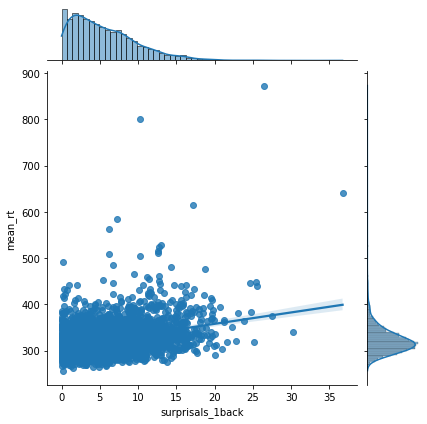

In [37]:
g = sns.jointplot(x="surprisals_1back", y="mean_rt", data=reg_df,
                  kind="reg")

In [41]:
# surprisals_oneback
#formula = 'mean_rt ~ len + ngram_prob'
formula = 'mean_rt ~ len + len_prev1 + len_prev2 + unigram_logprob + unigram_logprob_prev1 + unigram_logprob_prev2 + unigram_logprob_prev3'
mod0 = smf.glm(formula=formula, data=reg_df, family=sm.families.Gaussian(sm.genmod.families.links.Log())).fit()
print(mod0.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                mean_rt   No. Observations:                 4451
Model:                            GLM   Df Residuals:                     4443
Model Family:                Gaussian   Df Model:                            7
Link Function:                    Log   Scale:                          825.01
Method:                          IRLS   Log-Likelihood:                -21257.
Date:                Sat, 17 Sep 2022   Deviance:                   3.6655e+06
Time:                        13:35:52   Pearson chi2:                 3.67e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1694
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.76

In [42]:
# surprisals
formula = 'mean_rt ~ surprisals + surprisals_prev1 + surprisals_prev2 + surprisals_prev3 + len + len_prev1 + len_prev2 + unigram_logprob + unigram_logprob_prev1 + unigram_logprob_prev2 + unigram_logprob_prev3'
mod1 = smf.glm(formula=formula, data=reg_df, family=sm.families.Gaussian(sm.genmod.families.links.Log())).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                mean_rt   No. Observations:                 4451
Model:                            GLM   Df Residuals:                     4439
Model Family:                Gaussian   Df Model:                           11
Link Function:                    Log   Scale:                          782.07
Method:                          IRLS   Log-Likelihood:                -21136.
Date:                Sat, 17 Sep 2022   Deviance:                   3.4716e+06
Time:                        13:35:57   Pearson chi2:                 3.47e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2224
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.67

In [45]:
# surprisals_oneback
formula = 'mean_rt ~ surprisals_1back + surprisals_1back_prev1 + surprisals_1back_prev1 + surprisals_1back_prev2 + surprisals_1back_prev3 + len + len_prev1 + len_prev2 + len_prev3 + unigram_logprob + unigram_logprob_prev1 + unigram_logprob_prev2 + unigram_logprob_prev3'
mod2 = smf.glm(formula=formula, data=reg_df, family=sm.families.Gaussian(sm.genmod.families.links.Log())).fit()
print(mod2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                mean_rt   No. Observations:                 4451
Model:                            GLM   Df Residuals:                     4438
Model Family:                Gaussian   Df Model:                           12
Link Function:                    Log   Scale:                          770.53
Method:                          IRLS   Log-Likelihood:                -21102.
Date:                Sat, 17 Sep 2022   Deviance:                   3.4196e+06
Time:                        13:37:19   Pearson chi2:                 3.42e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2370
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

In [46]:
# surprisals_threeback
formula = 'mean_rt ~ surprisals_3back + surprisals_3back_prev1 + surprisals_3back_prev2 + surprisals_3back_prev3 + len + len_prev1 + len_prev2 + len_prev3 + unigram_logprob + unigram_logprob_prev1 + unigram_logprob_prev2 + unigram_logprob_prev3'
mod3 = smf.glm(formula=formula, data=reg_df, family=sm.families.Gaussian(sm.genmod.families.links.Log())).fit()
print(mod3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                mean_rt   No. Observations:                 4451
Model:                            GLM   Df Residuals:                     4438
Model Family:                Gaussian   Df Model:                           12
Link Function:                    Log   Scale:                          761.13
Method:                          IRLS   Log-Likelihood:                -21075.
Date:                Sat, 17 Sep 2022   Deviance:                   3.3779e+06
Time:                        13:37:48   Pearson chi2:                 3.38e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2488
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

In [47]:
# surprisals_tenback
formula = 'mean_rt ~ surprisals_10back + surprisals_10back_prev1 + surprisals_10back_prev2 + surprisals_10back_prev3 + len + len_prev1 + len_prev2 + len_prev3 + unigram_logprob + unigram_logprob_prev1 + unigram_logprob_prev2 + unigram_logprob_prev3'
mod4 = smf.glm(formula=formula, data=reg_df, family=sm.families.Gaussian(sm.genmod.families.links.Log())).fit()
print(mod4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                mean_rt   No. Observations:                 4451
Model:                            GLM   Df Residuals:                     4438
Model Family:                Gaussian   Df Model:                           12
Link Function:                    Log   Scale:                          759.96
Method:                          IRLS   Log-Likelihood:                -21072.
Date:                Sat, 17 Sep 2022   Deviance:                   3.3727e+06
Time:                        13:38:04   Pearson chi2:                 3.37e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2503
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [52]:
print('delta LL per word, 0-sents-back ' + str((mod1.llf - mod0.llf) / mod0.nobs))
print('delta LL per word, 1-sents-back ' + str((mod2.llf - mod0.llf) / mod0.nobs))
print('delta LL per word, 3-sents-back ' + str((mod3.llf - mod0.llf) / mod0.nobs))
print('delta LL per word, 10-sents-back ' + str((mod4.llf - mod0.llf) / mod0.nobs))

delta LL per word, 0-sents-back 0.027178797755254353
delta LL per word, 1-sents-back 0.034720917333819594
delta LL per word, 3-sents-back 0.040861336458759945
delta LL per word, 10-sents-back 0.0416276693104124
